In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.2 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import cv2
import timm
import pandas as pd

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_data_dir = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/train'
val_data_dir = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/val'
save_dir = '/content/drive/MyDrive/Assignment_Pixxel'
train_csv_path = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/train_triplet.csv'
val_csv_path = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/val_triplet.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCH = 20

cuda


In [5]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [6]:
class TripletNetworkDataset(Dataset):
        def __init__(self,csv_path, data_dir_path,transform=None):
            self.data_dir_path = data_dir_path
            self.transform = transform
            self.df = pd.read_csv(csv_path)

        def __len__(self):
            return len(self.df)

        def __getitem__(self,idx):
            anchor_name, pos_name, neg_name = self.df.iloc[idx]

            anchor_path = os.path.join(self.data_dir_path,anchor_name)
            pos_path = os.path.join(self.data_dir_path,pos_name)
            neg_path = os.path.join(self.data_dir_path,neg_name)

            anchor = cv2.imread(anchor_path)
            anchor = cv2.cvtColor(anchor, cv2.COLOR_BGR2RGB)
            anchor = Image.fromarray(anchor)

            pos = cv2.imread(pos_path)
            pos = cv2.cvtColor(pos, cv2.COLOR_BGR2RGB)
            pos = Image.fromarray(pos)

            neg = cv2.imread(neg_path)
            neg = cv2.cvtColor(neg, cv2.COLOR_BGR2RGB)
            neg = Image.fromarray(neg)

            if self.transform:
                anchor = self.transform(anchor)
                pos = self.transform(pos)
                neg = self.transform(neg)
            return anchor,pos,neg

In [7]:
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((228,228))])

validate_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((228,228))])


In [8]:
trainset = TripletNetworkDataset(csv_path = train_csv_path,
                                 data_dir_path = train_data_dir,
                                 transform = train_transform)
testset = TripletNetworkDataset(csv_path = val_csv_path,
                                data_dir_path = val_data_dir,
                                transform = validate_transform)

1280


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


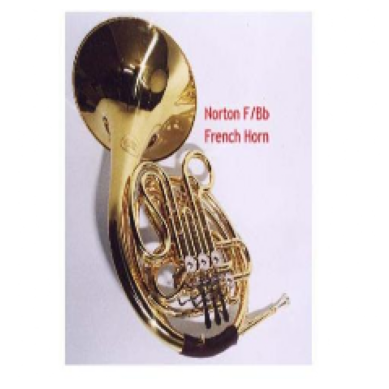

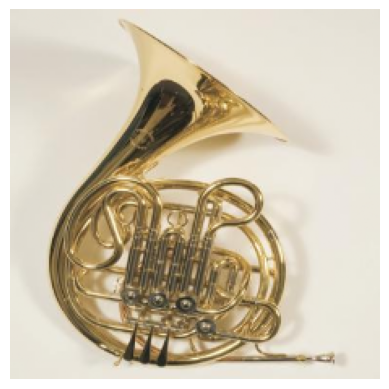

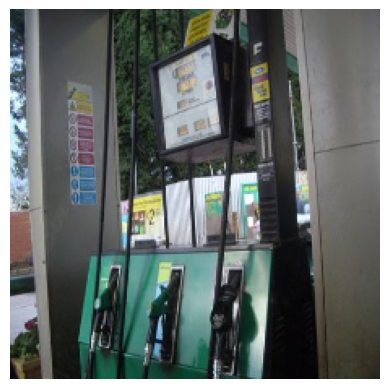

In [9]:
print(len(trainset))
anchor,pos,neg = trainset[0]
imshow(anchor)
imshow(pos)
imshow(neg)

In [10]:
trainloader = DataLoader(trainset,batch_size= 32,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:40
No. of Total examples:1280


In [11]:
testloader = DataLoader(testset,batch_size= 32)
print("No. of batches in trainloader:{}".format(len(testloader)))
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:10
No. of Total examples:320


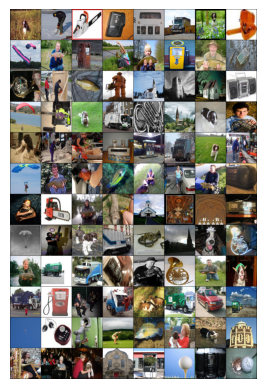

In [12]:
example_batch = next(iter(trainloader))
concatenated = torch.cat((example_batch[0],example_batch[1],example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))

## Model

In [13]:
class TripletClassificationNet(nn.Module):
    def __init__(self):
      super(TripletClassificationNet, self).__init__()
      self.embedding_net = timm.create_model('efficientnet_b0', pretrained = True)
      num_filters = self.embedding_net.classifier.in_features
      self.embedding_net.classifier = nn.Sequential(nn.Linear(num_filters,512),
                                                    nn.ReLU(),
                                                    nn.Linear(512,10))
    def forward(self, x1, x2, x3):
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)

        return output1, output2, output3

In [14]:
mymodel = TripletClassificationNet()

In [15]:
optimizer = optim.Adam(mymodel.parameters(),lr = LR )
criterion = nn.TripletMarginLoss()

In [16]:
class Trainer():

    def __init__(self,criterion = None,optimizer = None):

        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, model, train_loader,epoch):

        model.to(device)
        epoch_loss = 0.0

        for anchor, pos, neg in tqdm(train_loader):

          #take data to device
          anchor = anchor.to(device)
          pos = pos.to(device)
          neg = neg.to(device)

          # compute output
          anchor_emb, pos_emb, neg_emb = model(anchor,pos,neg)
          loss = self.criterion(anchor_emb, pos_emb, neg_emb)

          # compute gradient and do GD step
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          epoch_loss += loss.item()

        print(f'Epoch {epoch+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f}')
        return epoch_loss / len(trainloader)

    def validate(self, model, validationloader,epoch):

        model.to(device)
        valid_loss = 0.0

        with torch.no_grad():
          for anchor, pos, neg in tqdm(validationloader):

            #take data to device
            anchor = anchor.to(device)
            pos = pos.to(device)
            neg = neg.to(device)

            # compute output
            anchor_emb, pos_emb, neg_emb = model(anchor,pos,neg)
            loss = self.criterion(anchor_emb, pos_emb, neg_emb)

            valid_loss += loss.item()

          print(f'Epoch {epoch+0:03}: | Validation Loss: {valid_loss/len(validationloader):.5f}')
          return valid_loss / len(validationloader)

    def fit(self,model,trainloader,validationloader,epochs):

        valid_min_loss = np.Inf
        train_loss_epoch =[]
        test_loss_epoch = []
        for i in range(epochs):

            # switch to train mode
            model.train()
            avg_train_loss = self.train(model,trainloader,i) ###

            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss = self.validate(model,validationloader,i) ###

            #add loss of each epoch
            train_loss_epoch.append(avg_train_loss)
            test_loss_epoch.append(avg_valid_loss)

            if avg_valid_loss <= valid_min_loss :
                print("test_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),('/content/drive/MyDrive/Assignment_Pixxel/model_best.pt'))
                valid_min_loss = avg_valid_loss

        plt.plot(train_loss_epoch, label='training loss')
        plt.plot(test_loss_epoch, label='test loss')
        plt.title('Loss at the end of each epoch')
        plt.legend()
        plt.savefig('loss_plot.png')

100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Epoch 000: | Training Loss: 0.20933


100%|██████████| 10/10 [02:37<00:00, 15.80s/it]


Epoch 000: | Validation Loss: 0.30517
test_loss decreased inf --> 0.3051743656396866


100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Epoch 001: | Training Loss: 0.22596


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch 001: | Validation Loss: 0.34027


100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Epoch 002: | Training Loss: 0.17483


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch 002: | Validation Loss: 0.37508


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 003: | Training Loss: 0.11956


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch 003: | Validation Loss: 0.38325


100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


Epoch 004: | Training Loss: 0.09673


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch 004: | Validation Loss: 0.20892
test_loss decreased 0.3051743656396866 --> 0.20892414152622224


100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Epoch 005: | Training Loss: 0.10635


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Epoch 005: | Validation Loss: 0.26231


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 006: | Training Loss: 0.09260


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch 006: | Validation Loss: 0.33596


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 007: | Training Loss: 0.12735


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


Epoch 007: | Validation Loss: 0.31412


100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Epoch 008: | Training Loss: 0.05292


100%|██████████| 10/10 [00:08<00:00,  1.12it/s]


Epoch 008: | Validation Loss: 0.21238


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 009: | Training Loss: 0.07822


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Epoch 009: | Validation Loss: 0.29535


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 010: | Training Loss: 0.10452


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Epoch 010: | Validation Loss: 0.27796


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 011: | Training Loss: 0.08378


100%|██████████| 10/10 [00:08<00:00,  1.19it/s]


Epoch 011: | Validation Loss: 0.28237


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 012: | Training Loss: 0.11036


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]


Epoch 012: | Validation Loss: 0.39581


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 013: | Training Loss: 0.03971


100%|██████████| 10/10 [00:09<00:00,  1.07it/s]


Epoch 013: | Validation Loss: 0.30315


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 014: | Training Loss: 0.05075


100%|██████████| 10/10 [00:08<00:00,  1.11it/s]


Epoch 014: | Validation Loss: 0.38216


100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Epoch 015: | Training Loss: 0.04730


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch 015: | Validation Loss: 0.30676


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 016: | Training Loss: 0.04828


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]


Epoch 016: | Validation Loss: 0.28330


100%|██████████| 40/40 [00:50<00:00,  1.25s/it]


Epoch 017: | Training Loss: 0.05133


100%|██████████| 10/10 [00:09<00:00,  1.08it/s]


Epoch 017: | Validation Loss: 0.38248


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 018: | Training Loss: 0.04379


100%|██████████| 10/10 [00:10<00:00,  1.05s/it]


Epoch 018: | Validation Loss: 0.33048


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


Epoch 019: | Training Loss: 0.04775


100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


Epoch 019: | Validation Loss: 0.34387


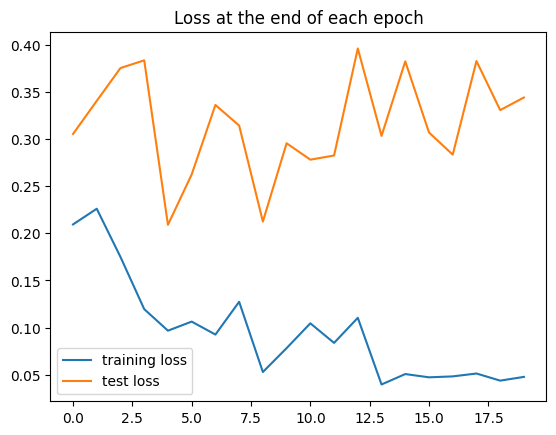

In [18]:
trainer = Trainer(criterion,optimizer)
trainer.fit(mymodel,trainloader,testloader,epochs = EPOCH)

### The above trained model will be used for prediction using a seperate prediction function

In [48]:
def predict(model, anchor, pos, neg):
    with torch.no_grad():
        anchor = anchor.unsqueeze(0)  # Add batch dimension
        pos = pos.unsqueeze(0)
        neg = neg.unsqueeze(0)

        anchor_out, pos_out, neg_out = model(anchor, pos, neg)
        # Calculate distances between embeddings
        distance_positive = torch.norm(anchor_out - pos_out, p=2)
        distance_negative = torch.norm(anchor_out - neg_out, p=2)

        # Make binary prediction based on distances
        threshold = 6 # determined by point nearest to the upper left corner of ROC Curve, a point where false positive and false negatives are minimized
        if distance_positive < threshold and distance_negative >= threshold:
            pred = 1
        else:
            pred = 0

        return pred

In [26]:
pred_model = TripletClassificationNet()
pred_model.load_state_dict(torch.load('/content/drive/MyDrive/Assignment_Pixxel/model_best_siamese_triplet.pt'))
pred_model.eval();

In [21]:
anchor, pos_image, neg_image = testset[10]
prediction = predict(pred_model,anchor,pos_image,neg_image)

In [49]:
y_pred_list = []
y_test = []
for imgs1, imgs2, imgs3 in tqdm(testset):

  # compute output
  pred_tag = predict(pred_model,imgs1,imgs2,imgs3)
  y_pred_list.append(pred_tag)
  y_test.append(1)

  0%|          | 0/320 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 320/320 [00:58<00:00,  5.43it/s]


In [50]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.73      0.84       320

    accuracy                           0.73       320
   macro avg       0.50      0.37      0.42       320
weighted avg       1.00      0.73      0.84       320



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
